# 데이터 분석

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.font_manager as fm
from matplotlib import gridspec

from data_func import to_pivot_mean_data
from data_func import to_pivot_mean_data_week
from data_func import to_pivot_each_data
from data_func import create_accident_list
from data_func import create_heatmap
from data_func import create_heatmap_minus
from data_func import create_3D_Graph
from data_func import contiueNum
from data_func import chage_datetime
from data_func import missing_precess

In [2]:
path = '../9.데이터/0.작업 데이터/0.전처리 데이터/'
path_3d = '../9.데이터/0.작업 데이터/9.3D 그래프/'
path_h = "../9.데이터/0.작업 데이터/2.사고 데이터/0.히트맵/"

In [3]:
## v1 버전이 속도 0인데 교통량 존재하는 데이터들 삭제한 데이터

up_data_v1 = pd.read_csv(path + 'upline_data_v1.csv', encoding='utf-8')
down_data_v1 = pd.read_csv(path + 'downline_data_v1.csv', encoding='utf-8')

In [4]:
up_data_v1["datetime"] = up_data_v1["통계날짜"] + " " + up_data_v1["통계시각"]
up_data_v1["datetime"] = pd.to_datetime(up_data_v1["datetime"], format='%Y-%m-%d %H:%M:%S', errors='raise')
up_data_v1["요일"] = up_data_v1["datetime"].dt.weekday

down_data_v1["datetime"] = down_data_v1["통계날짜"] + " " + down_data_v1["통계시각"]
down_data_v1["datetime"] = pd.to_datetime(down_data_v1["datetime"], format='%Y-%m-%d %H:%M:%S', errors='raise')
down_data_v1["요일"] = down_data_v1["datetime"].dt.weekday

## 사고데이터 분류 및 생성

In [7]:
create_accident_list(up_data_v1, "속도")
create_accident_list(down_data_v1, "속도")

## 3D 그래프, 등고선 그래프 생성

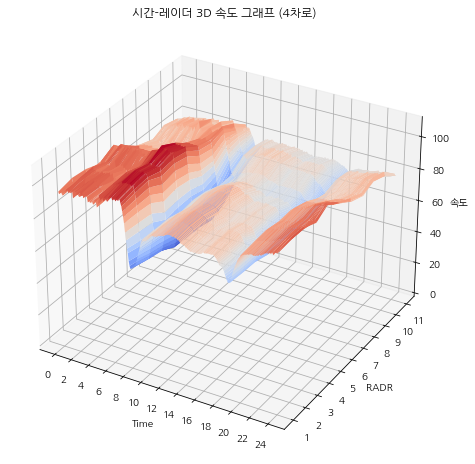

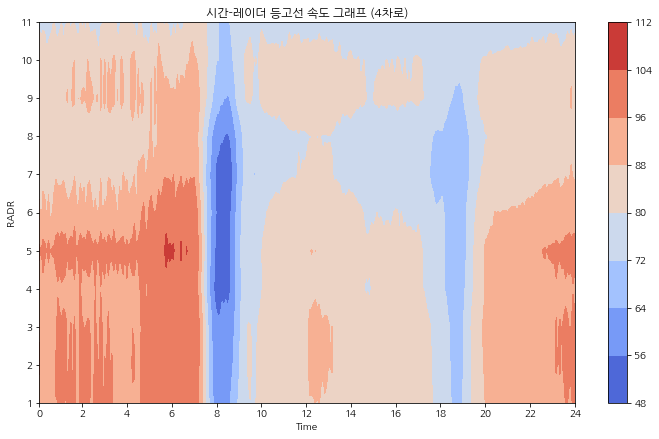

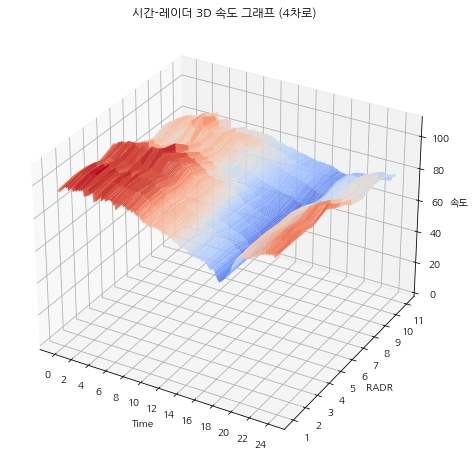

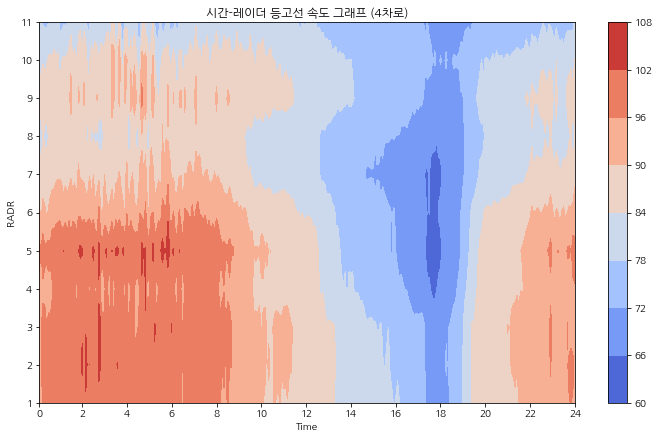

In [53]:
create_3D_Graph(up_data_v1, 4, "속도")